In [1]:
# pip install clipboard

In [4]:
# Image Captioning dependencies ----------------------------------------------------------------------
import tensorflow as tf
print("tensorflow:", tf.__version__)

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt
from PIL import Image

import collections
import random
import numpy as np
import os
import time
import json

from tqdm import tqdm # Show process
import pickle # Save tokenizer in pickle format to load for inference

# Image Captioning dependencies ------------------------------------------------------------------------

import time
from selenium import webdriver
from selenium.webdriver import Keys
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service

from bs4 import BeautifulSoup
import clipboard

# GPT-2 dependencies -----------------------------------------------------------------------------------

import torch
print("torch: ", torch.__version__)
import transformers 
from transformers import PreTrainedTokenizerFast
# from transformers import AutoModelWithLMHead # 이 라인이 필요한지 확인
from fastai.text.all import *

import fastai
import re
from typing import Optional

from transformers import GPT2LMHeadModel # Using only GPT2LM Head Model
from transformers import PreTrainedTokenizerFast # tokenizer

import time 

tensorflow: 2.6.0
torch:  1.12.0


# Image Captioning with Visual Attention

Prediction Caption: cat laying on its person.


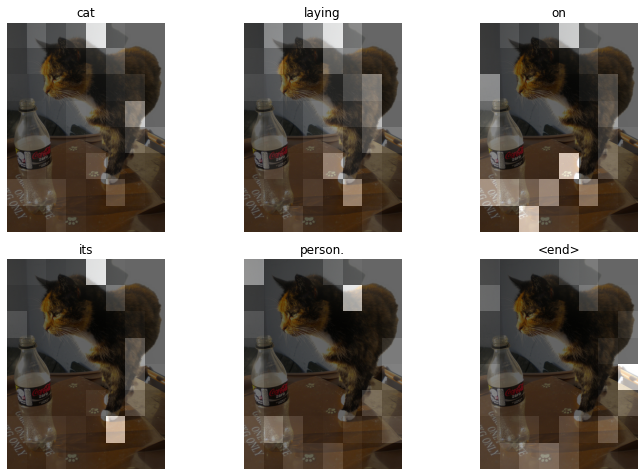

Image Captioning Inference Time:  11.14578914642334


In [10]:
# Starting time
imagecaptioning_start = time.time()

# Max word count for a caption
MAX_LENGTH = 50
# Use the top VOCABULARY_SIZE words for a vocabulary
VOCABULARY_SIZE = 7000

# Calculates the max_length, which is used to store the attention weights
max_length = 52
units = 512
attention_features_shape = 64

# Load tokenizer pickle file

# Korean Reference:
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# English Reference:
# Override the default standardization of TextVectorization
# to preserve "<", ">" (<start>, <end>)
def standardize(inputs):
    inputs = tf.strings.lower(inputs) # convert to lowercase
    return tf.strings.regex_replace(inputs, # change input into
                                    r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "") # pattern -> rewrite 

from_disk = pickle.load(open("tokenizer.pickle", "rb"))
# You have to call `adapt` with some dummy data (BUG in Keras)
tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
tokenizer.set_weights(from_disk['weights'])

word_to_index = tf.keras.layers.StringLookup( # preprocessing layer to map string features to intger indices
    mask_token="", 
    vocabulary=tokenizer.get_vocabulary()
)

index_to_word = tf.keras.layers.StringLookup( # preprocessing layer to map string features to intger indices
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)

# Image preprocessing
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Load InceptionV3 model with pretrained Imagenet weights

image_model = tf.keras.applications.InceptionV3(include_top=False, # does not include fully connected layer('top')
                                                weights='imagenet' # load pretrained weights
                                               )

# Use only certain parts of the model
new_input = image_model.input
hidden_layer = image_model.layers[-1].output # in this case, using all the layers of InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 

def evaluate(image, encoder, decoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = tf.zeros((1, units)) # (the number of images to be trained, units)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index(tf.constant('<start>'))], 0) # convert tuple to tensor
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(tf.cast(dec_input, tf.int64), # cast type tf.int64
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(tf.constant(predicted_id)).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Show original image(image), created words(result), (attention_plot) 
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image)) # load original image into array

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result) 
    for i in range(len_result): # show plot with each created words
        temp_att = np.resize(attention_plot[i], (8, 8)) # resize attention_plot
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(int(grid_size), int(grid_size), i + 1)
        ax.set_title(result[i]) # show each created word
        img = ax.imshow(temp_image)
        plt.axis('off')
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent()) # show original image with attention_plot

    plt.tight_layout()
    plt.show()
    
test_image_path = os.getcwd() + '.\\test_images\\demo.jpg'

result, attention_plot = evaluate(
    test_image_path,
    encoder=tf.keras.models.load_model('my_encoder'),
    decoder=tf.keras.models.load_model('my_decoder'),
)

# Remove [UNK], <end>
prediction_result = []
for word in result:
    if word not in ['[UNK]', '<end>']:
        prediction_result.append(word)

prediction_string = ' '.join(prediction_result)

print('Prediction Caption:', prediction_string)
plot_attention(test_image_path, result, attention_plot)

# Inference time
imagecaptioning_time = time.time() - imagecaptioning_start
print("Image Captioning Inference Time: ", imagecaptioning_time)

# Translation

In [11]:
translation_start = time.time()

def EngtoKor(txt_eng):
    txt=txt_eng+'.'
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_experimental_option('detach',True)
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=chrome_options)

    #driver.maximize_window()

    driver.get('https://papago.naver.com/')
    time.sleep(3)

    # 번역할 내용 입력
    driver.find_element(By.CLASS_NAME, 'edit_box___1KtZ3').send_keys(txt)
    time.sleep(1)

    # 번역 버튼 클릭
    driver.find_element(By.CLASS_NAME, 'btn_text___3-laJ').click()
    time.sleep(3)

    # 번역된 내용 복사 버튼 눌러 복사하기
    driver.find_element(By.XPATH, '//*[@id="root"]/div/div[1]/section/div/div[1]/div[2]/div/div[7]/span[2]/span/span/button').click()
    time.sleep(2)

    result = clipboard.paste()
    return str(result)

translation_result = EngtoKor(prediction_string)
print(translation_result)

# Inference time
translation_time = time.time() - translation_start
print("Translation Time (Crawling): ", translation_time)


고양이가 엎드려 있다.
Translation Time (Crawling):  13.694435834884644


# KoGPT-2

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


KoGPT Time:  9.799286365509033
Total Inference Time: 34.639511


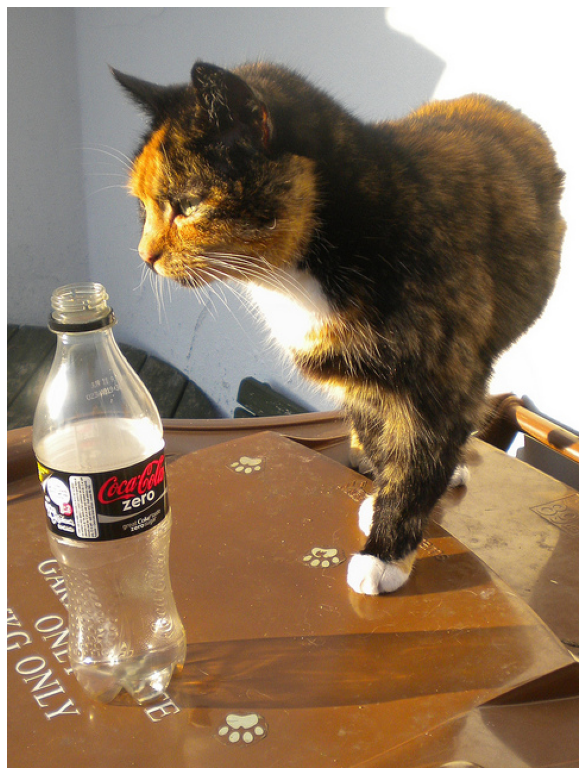

In [12]:
kogpt_start = time.time()

# Load tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", bos_token='</s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>', mask_token='<mask>') 

# Load model
model = GPT2LMHeadModel.from_pretrained(r"C:\Users\HP\Desktop\RAPA\ImageCaptioning_Translation_GPT2_with_7080KoreanSongs\KoGPT_model\kogpt2_model_finetunned_비출판물말뭉치_일기_2batch_6epochs") 

# Inference with model
text = translation_result
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())

# Inference result:
# Text completion result
plt.figure(figsize=(12, 14))
# Original image
image = Image.open(test_image_path)
plt.axis('off')
plt.imshow(image)

# Inference time
kogpt_time = time.time() - kogpt_start
print("KoGPT Time: ", kogpt_time)

# Total Inference time
print("Total Inference Time: {:.6f}".format(imagecaptioning_time + translation_time + kogpt_time))

# KoGPT-2 model trained with novel, poem, IU lyrics

In [ ]:
# Load tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", bos_token='</s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>', mask_token='<mask>') 

# Load model
model = GPT2LMHeadModel.from_pretrained("kogpt_model_finetunned_all") # GPT2LMHeadModel/ AutoModelWithLMHead 확인

# Inference with model
text = translation_result
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())

plt.figure(figsize=(12, 14))
image = Image.open(test_image_path)
plt.axis('off')
plt.imshow(image)

print(generated)
print("Prediction time: ", time.time() - start)

한 여자가 노란 셔츠를 입고 말을 걷는다. 무더댓살이의 흐뭇한 목덜미에다 나는 너의 단숨을 쉬었지 않는 소리로 어머니를 보았으나 결코 나에게 안겨 주지 않았느냐고 물었을 뿐이었어요 어머니의 목소리가 너무도 들렸단 말이오 그 순간 나의 입에서 내 눈빛에 잠겨지지 않은 음침소리는 여전히 나를 보고 싶어하는 것이었습니 다급한 현재의 아름다움으로 변명처럼 내게서 빛을 남겨진 당신의 맑은 정신으로는 내가 왜 그렇게 말씀하시는가 모르겠습니까 그러나 이미 나 자신의 인생이란 걸 알게 되겠죠 당신은 정말이지 네 자신이 없어졌는지 모릅


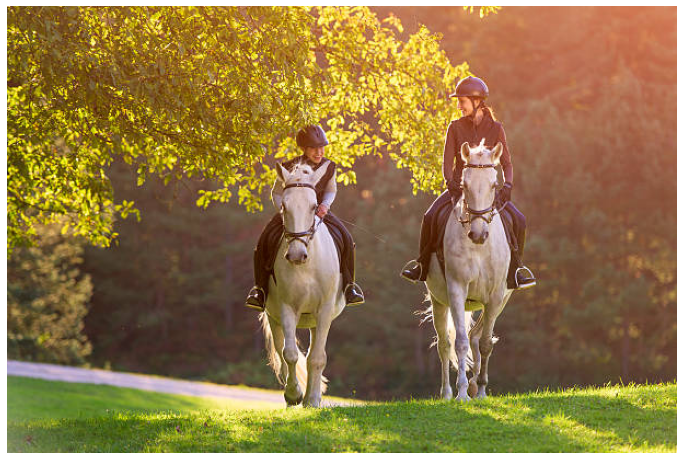

In [16]:
# result of 현대소설1, 현대소설2, 시1, 시2, 아이유 

# 

In [13]:
translation_result = '메타버스'

# Load tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", bos_token='</s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>', mask_token='<mask>') 

# Load model
model = GPT2LMHeadModel.from_pretrained(r"C:\Users\HP\Desktop\RAPA\ImageCaptioning_Translation_GPT2_with_7080KoreanSongs\KoGPT_model\kogpt2_model_finetunned_비출판물말뭉치_일기_2batch_6epochs") 


for char in translation_result:
    # Inference with model
    text = char
    input_ids = tokenizer.encode(text)
    gen_ids = model.generate(torch.tensor([input_ids]),
                               max_length=20,
                               repetition_penalty=2.0,
                               pad_token_id=tokenizer.pad_token_id,
                               eos_token_id=tokenizer.eos_token_id,
                               bos_token_id=tokenizer.bos_token_id,
                             do_sample=True,
                             top_k=30, #0-50사이 값 높을수록 굳
                             top_p=0.95, #0-1사이 값 높을수록 굳
                               use_cache=True
                            )
    generated = tokenizer.decode(gen_ids[0,:].tolist())
    
    print(char, ':', generated)
    print(char, ':', generated.split('.')[0])

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


메 : 메 날짜가 있다고 하지만 그게 되는 것 같아서 더 좋은 결과를 보게 된 이 기분일도
메 : 메 날짜가 있다고 하지만 그게 되는 것 같아서 더 좋은 결과를 보게 된 이 기분일도
타 : 타인이어야 하는 사람같은 것이 아니었으니까. 내가 하고싶다.
20여행이 전날 밤을
타 : 타인이어야 하는 사람같은 것이 아니었으니까
버 : 버스는 매우 가까운 곳에 오는 듯하다. 그냥 자꾸만 해도 손에 잡았으면 좋겠다.

버 : 버스는 매우 가까운 곳에 오는 듯하다
스 : 스프며, 밥은 소란을 피우적이었다. 매일 먹고 숙소 짐을 풀고 그나마 휴식을
스 : 스프며, 밥은 소란을 피우적이었다
